In [25]:
from pathlib import Path

import numpy as np
from astropy.io import fits

# Define where the directory is located
datadir = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope"

# Use pathlib.Path to create a pathobject
pathobject = Path(datadir)

myfitsfiles = []

# Loop over all files in the directory and grab the fits files
for f in pathobject.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles.append(f)

# Print first 10 fitsfiles to check if we got everything correct        
for i in range(10):
    print(myfitsfiles[i])

\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000001.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000002.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000003.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000004.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000005.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000006.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000007.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000008.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000009.BIAS.FIT
\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000010.BIAS.FIT


In [26]:
# Create the image class

class image:
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_date_obs=0, fits_naxis1=0, fits_naxis2=0, pixelsize=18):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.date_obs = fits_date_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2
        self.pixelsize = pixelsize

myimages = []

# Loop over all of the filepaths in myfitsfiles, open each image, give it the image class and append it to the list of images
for filepath in myfitsfiles:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ')) 
    myimages.append(newimage)
    hdulist.close()

# Comment for self: Dark Frame, Bias Frame, Flat Field, Light Frame

436.0 12912.0 449.2079908297178


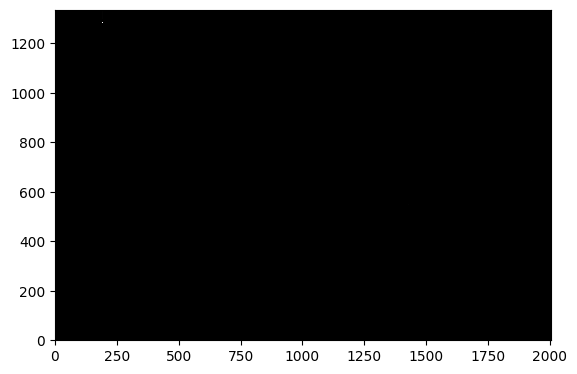

In [27]:
# Create the masterbias

from matplotlib.pyplot import figure, show, close
from astropy.visualization import ImageNormalize, SquaredStretch

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Bias_list = []
count = 0
for im in myimages:
    if 'bias frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Bias_list.append(dat)
        hdulist.close

# Then we median combine the images        
Bias_stack = np.stack(Bias_list)
masterbias = np.median(Bias_stack, axis=0)

# These look pretty good, just weird it doesn't show up on the plot
print(masterbias.min(), masterbias.max(), masterbias.mean())

# Show the resulting masterbias
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterbias, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

-0.8833333333333333 58.656666666666666 0.0015189325689937494


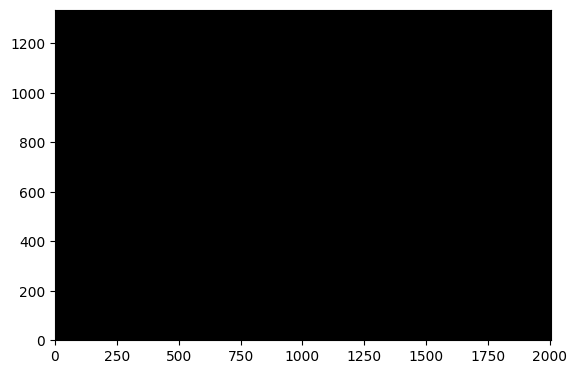

In [28]:
# Create the masterdark

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Darks_list = []
count = 0
for im in myimages:
    if 'dark frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Darks_list.append((dat - masterbias)/im.exptime)
        hdulist.close

# Then we median combine the darks
Darks_stack = np.stack(Darks_list)
masterdark = np.median(Darks_stack, axis=0)

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterdark.min(), masterdark.max(), masterdark.mean())

# Show the resulting masterdark
fig = figure()
frame = fig.add_subplot(1,1,1)
norm = ImageNormalize(vmin=5, vmax=100, stretch=SquaredStretch())
frame.imshow(masterdark, interpolation='none', origin='lower', cmap='gray', norm=norm)
show(fig)
close(fig)


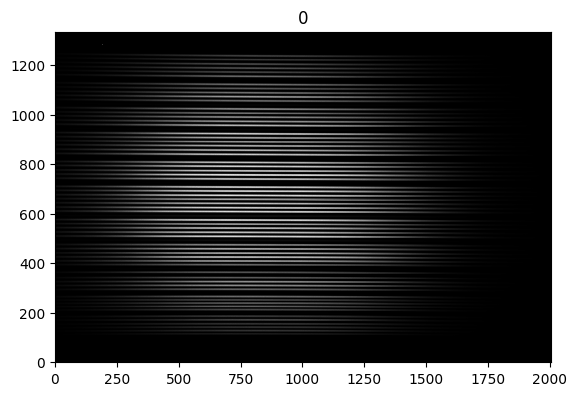

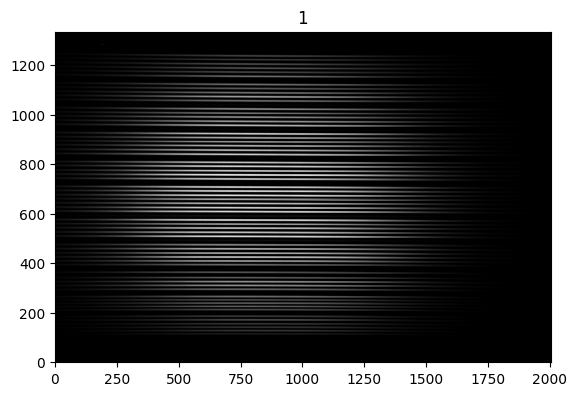

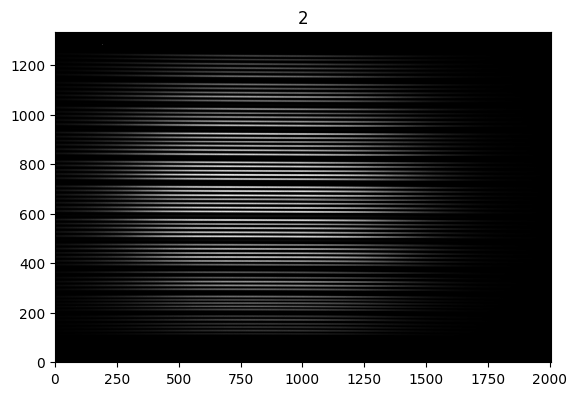

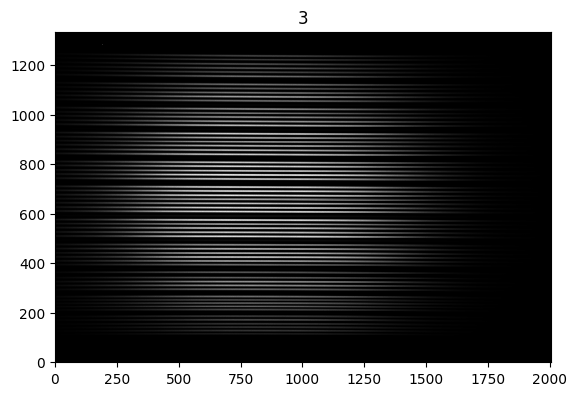

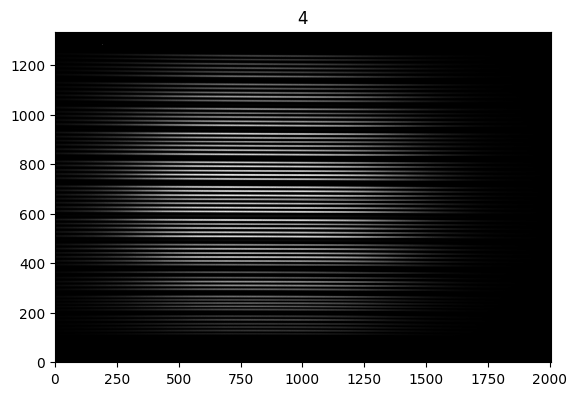

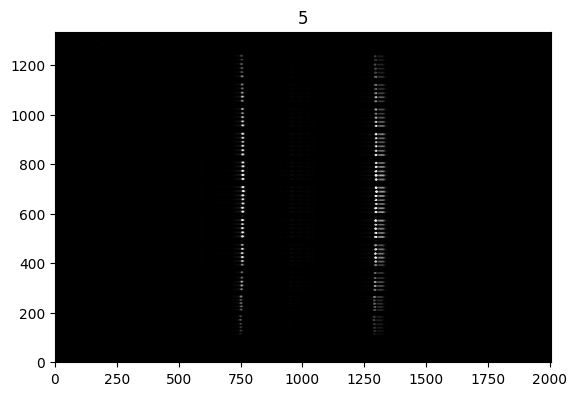

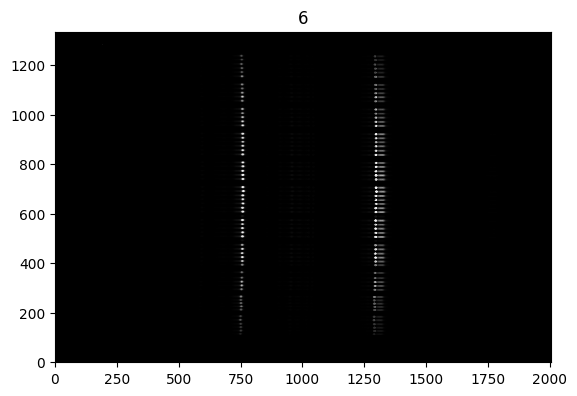

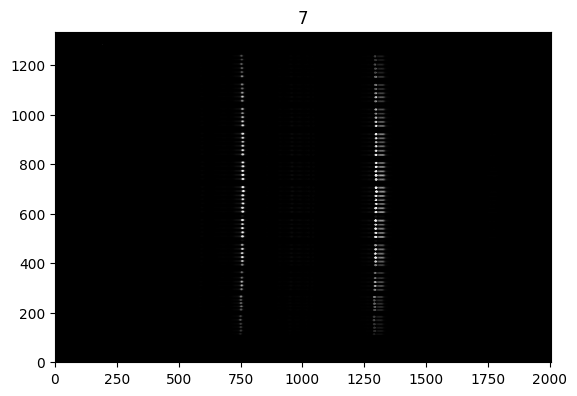

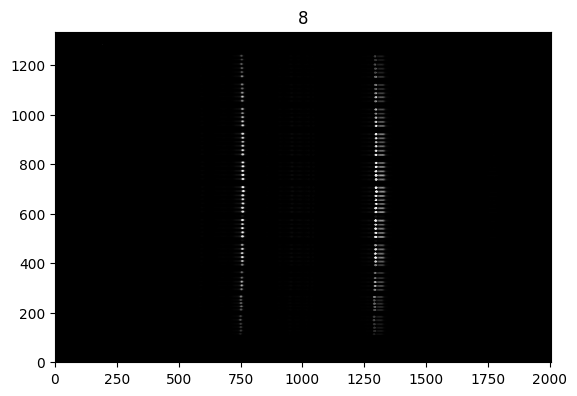

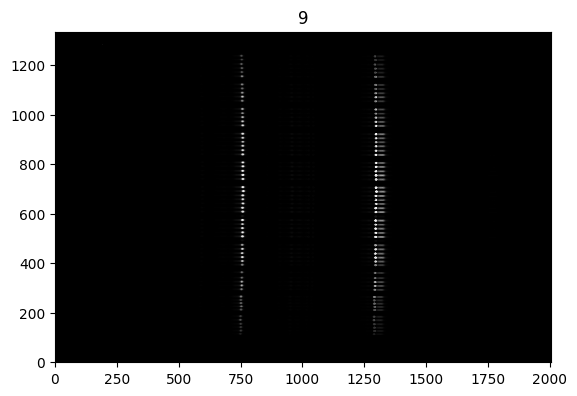

In [29]:
# Let's do the masterflat next

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Flats_list = []
count = 0
for im in myimages:
    if 'flat field' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Flats_list.append(dat)
        hdulist.close

# Lets inspect the Flats
c = 0
for obj in Flats_list:
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    norm = ImageNormalize(stretch=SquaredStretch())
    frame.imshow(obj, interpolation='none', origin='lower', cmap='gray', norm=norm)
    frame.set_title(c)
    show(fig)
    close(fig)
    c += 1

# We see that the first 5 show a proper flat
Flats_list_sorted = Flats_list[0:4]

-0.07895550061804697 11.148331273176762 2.1313095927334027


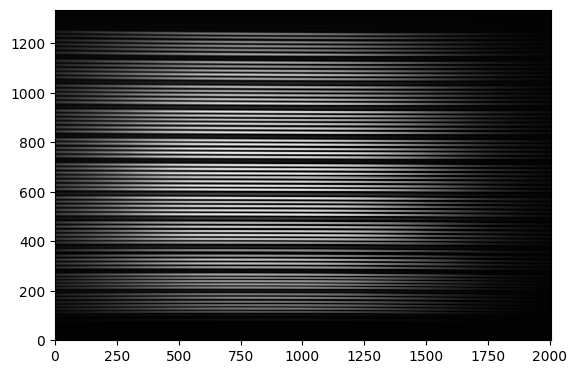

In [30]:
# Then we calibrate the flats with masterbias and median combine the images (We don't need to concern with the darks as the dark current can't really build up during flats
Flats_stack = np.stack(Flats_list_sorted-masterbias)
Flats_median = np.median(Flats_stack)
Flats_stack_normalized = Flats_stack/Flats_median
masterflat = np.median(Flats_stack_normalized, axis=0)

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterflat.min(), masterflat.max(), masterflat.mean())

# Show the resulting masterflat
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterflat, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

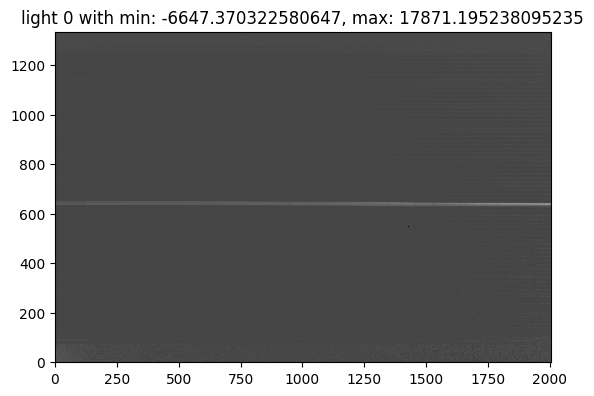

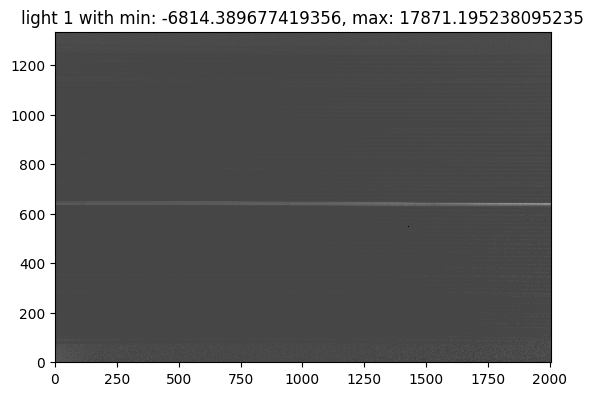

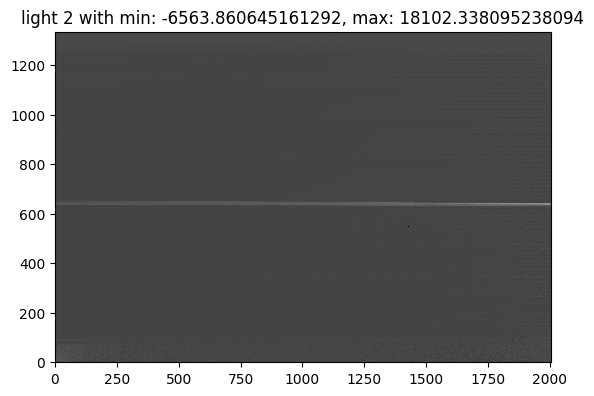

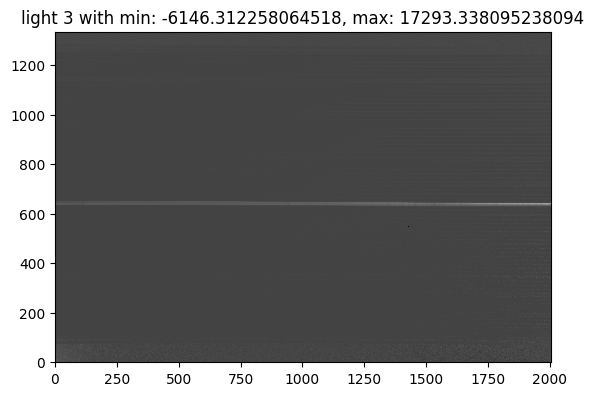

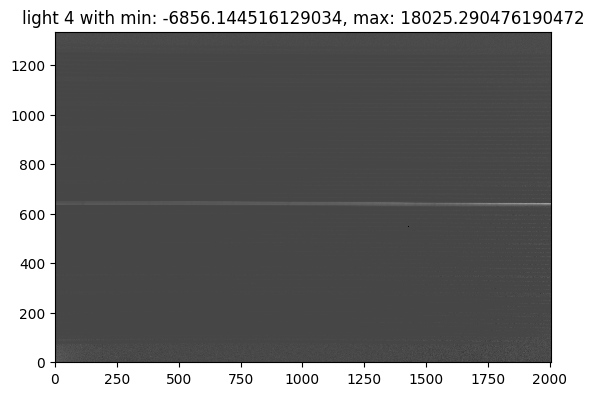

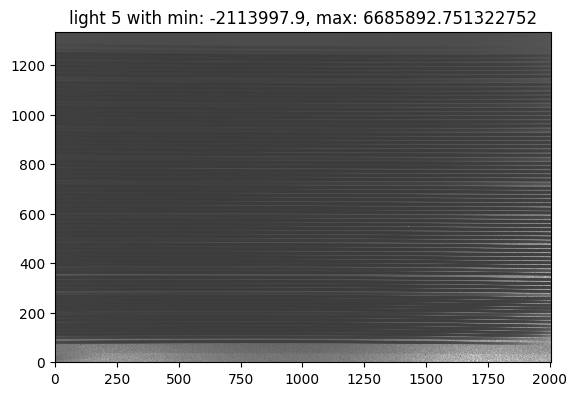

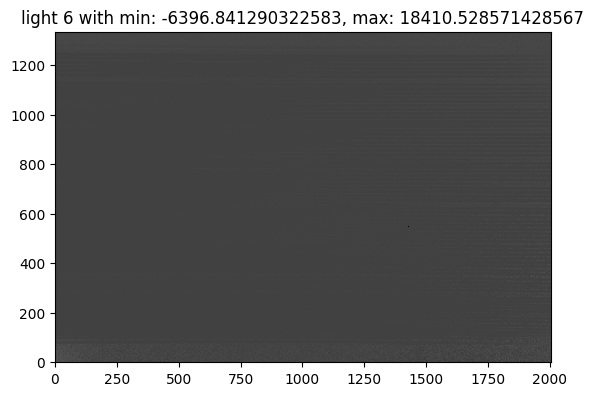

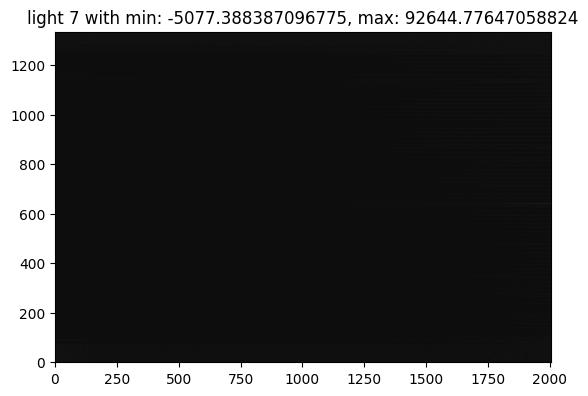

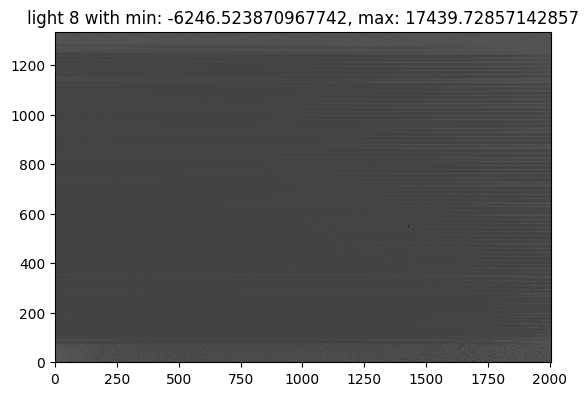

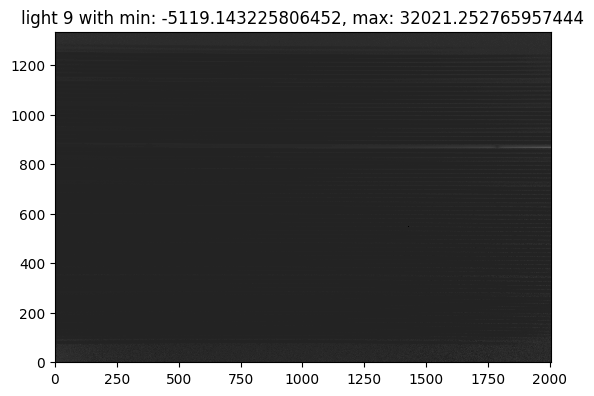

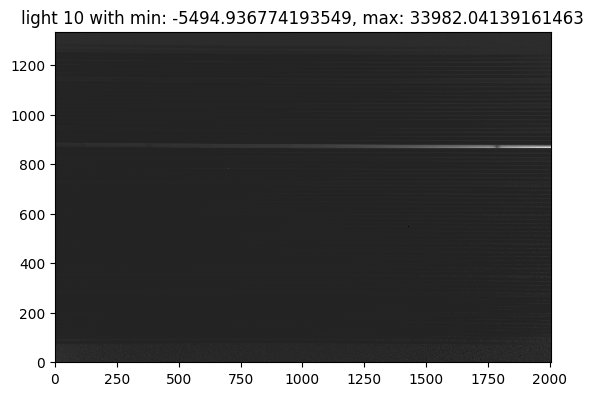

In [31]:
# Now that we have our master calibration files we can work on our lights, first we calibrate
lights = []
for im in myimages:
    if 'light frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        data = hdulist[0].data.astype(float)
        data -= masterdark*im.exptime + masterbias
        data /= masterflat
        lights.append(data)
        hdulist.close
        
# Let's inspect the lights
c = 0
for obj in lights:
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    frame.imshow(obj, interpolation='none', origin='lower', cmap='gray')
    frame.set_title(f"light {c} with min: {obj.min()}, max: {obj.max()}")
    show(fig)
    close(fig)
    c += 1

-6647.370322580647 17871.195238095235 119.07366463138834


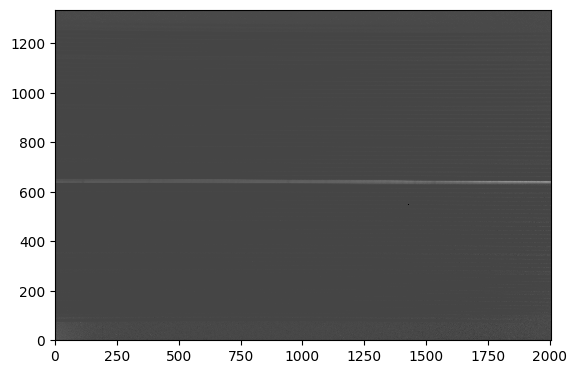

In [32]:
# We use just the first 5, since they appear to be of the same target
lights_stack = np.stack(lights[:5:1])
masterlight = np.median(lights_stack, axis=0)

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterlight.min(), masterlight.max(), masterlight.mean())

# Show the resulting masterlight
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterlight, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

In [33]:
# Now that we have a program which calibrates the images we can start on figuring out where the spectral lines are. This is easiest done by using the flat frames first slice in a vertical line

vert_slice = masterflat[:,1000]

# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(vert_slice)
# show(fig)
# close(fig)

# Based on the plot we want to exclude values with less then 10000 counts
fibre_locations = np.where(vert_slice>2.5)[0]

# Now we would like to group all of the values in a single fibre into a single median value to reduce noise, although we do clearly see that the values on the outside are significantly less then the ones in the center.
fibre_locations_dict = {}
i = 1
n = "fibre_0"
c = 0

for obj in fibre_locations:
    try:
        if obj+1 == fibre_locations[i]:
            try:
                fibre_locations_dict[n].append(obj)
            except:
                fibre_locations_dict[n] = []
                fibre_locations_dict[n].append(obj)
        else:
            fibre_locations_dict[n].append(obj)
            c+=1
            n = f'fibre_{c}'        
        i+=1
    
    except:
        fibre_locations_dict[n].append(obj)
print(fibre_locations_dict)

{'fibre_0': [110, 111, 112, 113, 114, 115, 116], 'fibre_1': [122, 123, 124, 125, 126, 127, 128, 129, 130], 'fibre_2': [136, 137, 138, 139, 140, 141, 142, 143, 144], 'fibre_3': [150, 151, 152, 153, 154, 155, 156, 157], 'fibre_4': [165, 166, 167, 168, 169, 170, 171, 172, 173, 174], 'fibre_5': [179, 180, 181, 182, 183, 184, 185, 186, 187, 188], 'fibre_6': [206, 207, 208, 209, 210, 211, 212, 213, 214, 215], 'fibre_7': [219, 220, 221, 222, 223, 224, 225, 226, 227, 228], 'fibre_8': [232, 233, 234, 235, 236, 237, 238, 239, 240, 241], 'fibre_9': [246, 247, 248, 249, 250, 251, 252, 253, 254], 'fibre_10': [259, 260, 261, 262, 263, 264, 265, 266, 267, 268], 'fibre_11': [288, 289, 290, 291, 292, 293, 294, 295, 296, 297], 'fibre_12': [303, 304, 305, 306, 307, 308, 309, 310, 311, 312], 'fibre_13': [318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328], 'fibre_14': [336, 337, 338, 339, 340, 341, 342, 343, 344], 'fibre_15': [357, 358, 359, 360, 361, 362, 363, 364, 365], 'fibre_16': [387, 388, 389, 39

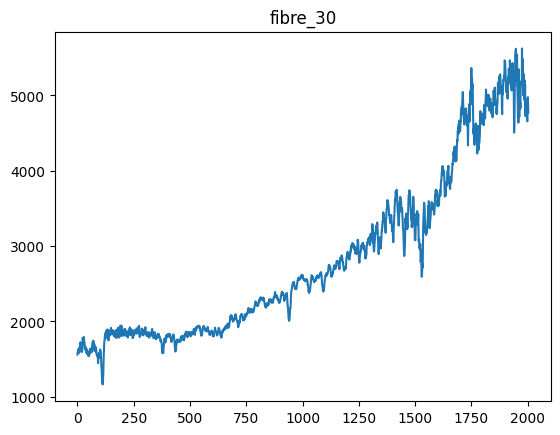

In [34]:
# Now that we have the locations of the fibres we make an intensity plot of the median of all the collumns that a fibre consists of.
def find_maximum_slice(horizontal_slice_dict):
    '''
    :purpose: Finds the location of the slice which contains the maximum value
    :input: Dictionary medians of horizontal slices
    :return: The location of the slice which contains the maximum value
    '''
    Total_max = np.max(horizontal_slice_dict['fibre_0'])
    for i in horizontal_slice_dict:
        Max_of_row = np.max(horizontal_slice_dict[i])
        if Max_of_row>Total_max:
            Total_max = Max_of_row
            location = i
    return location

horizontal_slice_dict = {}

# Loop over all the fibres
for i in fibre_locations_dict:
    # Do the slicing
    horizontal_slice = masterlight[fibre_locations_dict[i],:]
    # Take the median
    horizontal_slices_median = np.median(horizontal_slice, axis=0)
    # Add this median line to the dictionary
    horizontal_slice_dict[i] = horizontal_slices_median

location_of_maximum = find_maximum_slice(horizontal_slice_dict)

# Plot fibre 30
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(horizontal_slice_dict[location_of_maximum])
frame.set_title(location_of_maximum)
show(fig)
close(fig)